In [ ]:
pip install cbpro

In [3]:
import cbpro
public_client = cbpro.PublicClient()

In [ ]:
# public_client.get_products()
# # Get the order book at the default level.
# public_client.get_product_order_book('BTC-USD')
# # Get the order book at a specific level.
# public_client.get_product_order_book('BTC-USD', level=1)
# # Get the product ticker for a specific product.
# public_client.get_product_ticker(product_id='ETH-USD')
# # Get the product trades for a specific product.
# # Returns a generator
# gen = public_client.get_product_trades(product_id='ETH-USD')
# next(gen)
# public_client.get_product_historic_rates('ETH-USD')
# # To include other parameters, see function docstring:
# public_client.get_product_historic_rates('ETH-USD', granularity=3600)
# public_client.get_product_24hr_stats('ETH-USD')
# public_client.get_currencies()
# public_client.get_time()

In [229]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

out_df_list_by_year = []

for year in range(2015, 2021+1):
    out_df_list = []

    for month in tqdm(range(1, 13)):
        if month < 12:
            year_adj = year
            month_adj = month
        else:
            year_adj = year + 1
            month_adj = 0

        _hist_rates = public_client.get_product_historic_rates(
            product_id="BTC-USD",
            start="{}-{:02d}-01T00:00:00+0000".format(year, month),
            end="{}-{:02d}-01T00:00:00+0000".format(year_adj, month_adj+1),
            granularity=21600*4,
        )
        if len(_hist_rates) == 0:
            continue
        _out_df = pd.DataFrame(_hist_rates)
        _out_df.columns = [
            "TIME",
            "LOW",
            "HIGH",
            "OPEN",
            "CLOSE",
            "VOLUME",
        ]
        out_df_list.append(_out_df)

    _out_df2 = pd.concat(out_df_list, axis=0, ignore_index=True)

    _out_df2["TIME"] = _out_df2.TIME.apply(lambda x: pd.to_datetime(x*1e9))
    _out_df2 = _out_df2[_out_df2.TIME.apply(lambda x: x.year==year)]
    _out_df2 = _out_df2.sort_values(by="TIME")
    _out_df2 = _out_df2.set_index(keys="TIME")

    out_df_list_by_year.append(_out_df2)

out_df = pd.concat(out_df_list_by_year, axis=0, ignore_index=False)

100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


In [185]:
# _hist_rates = public_client.get_product_historic_rates(
#     product_id="BTC-USD",
#     start="2021-08-01T00:00:00+0000",
#     end="2021-08-02T00:00:00+0000",
#     granularity=300,
# )
# _out_df = pd.DataFrame(_hist_rates)
# _out_df.columns = [
#     "TIME",
#     "LOW",
#     "HIGH",
#     "OPEN",
#     "CLOSE",
#     "VOLUME",
# ]
# _out_df["TIME"] = _out_df.TIME.apply(lambda x: pd.to_datetime(x*1e9))
# _out_df = _out_df.sort_values(by="TIME")
# _out_df = _out_df.set_index(keys="TIME")
# out_df = _out_df.copy()

In [230]:
out_df

,LOW,HIGH,OPEN,CLOSE,VOLUME
TIME,,,,,
2015-07-20,277.37,280.00,277.98,280.00,782.883420
2015-07-21,276.85,281.27,279.96,277.32,4943.559434
2015-07-22,275.01,278.54,277.33,277.89,4687.909383
2015-07-23,276.28,279.75,277.96,277.39,5306.919575
2015-07-24,276.43,291.52,277.23,289.12,7362.469083
...,...,...,...,...,...
2021-08-08,43131.97,45363.83,44628.11,43829.14,18712.271582
2021-08-09,42821.30,46497.42,43829.15,46285.48,19464.724935
2021-08-10,44650.27,46718.44,46280.00,45595.66,13756.500669


In [231]:
ALPHA = 0.01
BOLLINGER_CONST = 0.2

out_df["EMA"] = out_df.CLOSE.ewm(alpha=ALPHA, adjust=True).mean()
# Forget about volatility for now, use stationary Bollinger bands
out_df["BOLLINGER_UPPER"] = out_df.EMA * (1 + BOLLINGER_CONST)
out_df["BOLLINGER_LOWER"] = out_df.EMA * (1 - BOLLINGER_CONST)
out_df["BUY_IND"] = (out_df.CLOSE < out_df.BOLLINGER_LOWER) * 1.0
out_df["SELL_IND"] = (out_df.CLOSE > out_df.BOLLINGER_UPPER) * 1.0

In [232]:
port_df = pd.DataFrame(
    {
        "TIME": [out_df.index[0]],
        "BTC_SHARES": [0.0],
        "USD_AMT": [1_000],
        "ACTION": ["sell"],
    }
)


In [233]:
MONEY_TO_INVEST_INIT = 1_000
FIXED_AMT_WHEN_BUY = False

for i in range(1, len(out_df)):
    btc_shares = port_df.tail(1).BTC_SHARES.values[0]
    usd_amt = port_df.tail(1).USD_AMT.values[0]
    action = "hold"

    if out_df.iloc[i].BUY_IND == 1.0 and \
        port_df.tail(1).ACTION.values[0] == "sell":
        if FIXED_AMT_WHEN_BUY:
            money_to_invest = MONEY_TO_INVEST_INIT
        else:
            money_to_invest = port_df.tail(1).USD_AMT.values[0]
        btc_shares += money_to_invest / out_df.iloc[i].CLOSE
        usd_amt -= money_to_invest
        action = "buy"

    elif out_df.iloc[i].SELL_IND == 1.0 and \
        port_df.tail(1).ACTION.values[0] == "buy":
        usd_amt += btc_shares * out_df.iloc[i].CLOSE
        btc_shares = 0.0
        action = "sell"

    else:
        continue

    _df = pd.DataFrame(
        {
            "TIME": [out_df.iloc[i].name],
            "BTC_SHARES": [btc_shares],
            "USD_AMT": [usd_amt],
            "ACTION": [action],
        }
    )

    port_df = pd.concat([port_df, _df], axis=0, ignore_index=True)

In [234]:
port_df

,TIME,BTC_SHARES,USD_AMT,ACTION
0,2015-07-20,0.000000,1000.000000,sell
1,2015-08-24,4.735745,0.000000,buy
2,2015-10-28,0.000000,1440.092821,sell
3,2018-02-05,0.208552,0.000000,buy
4,2018-02-17,0.000000,2319.413703,sell
5,2018-03-29,0.327601,0.000000,buy
6,2019-05-04,0.000000,1890.259923,sell
7,2019-11-24,0.273608,0.000000,buy
8,2020-02-09,0.000000,2782.143011,sell
9,2020-03-12,0.572799,0.000000,buy


In [235]:
0.181296 * out_df.tail(1).CLOSE.values[0]

8370.74633616

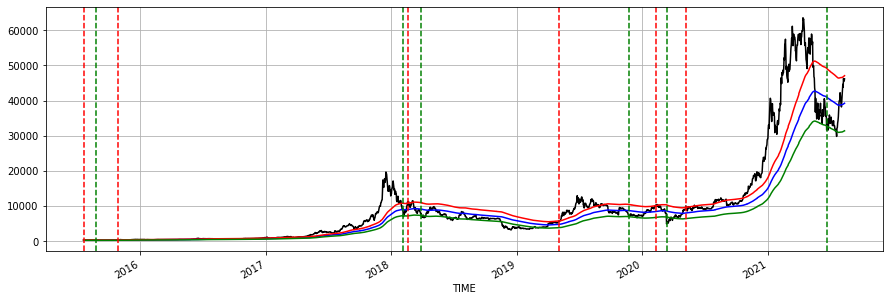

In [236]:
fig, ax = plt.subplots(figsize=(15,5))

out_df.CLOSE.plot(ax=ax, color="black")
out_df.CLOSE.ewm(alpha=ALPHA).mean().plot(ax=ax, color="blue")
(out_df.CLOSE.ewm(alpha=ALPHA).mean()*(1.0+BOLLINGER_CONST)).plot(ax=ax, color="red")
(out_df.CLOSE.ewm(alpha=ALPHA).mean()*(1.0-BOLLINGER_CONST)).plot(ax=ax, color="green")

[ax.axvline(x=port_df.iloc[i].TIME, color="red", linestyle="--") \
    for i in range(len(port_df)) if port_df.iloc[i].ACTION=="sell"]
[ax.axvline(x=port_df.iloc[i].TIME, color="green", linestyle="--") \
    for i in range(len(port_df)) if port_df.iloc[i].ACTION=="buy"]
ax.grid();